# Value-based method: Q Learning

In the first notebook of the day, we will learn about one of the most popular RL algorithms: Q Learning !

**Key facts**:
- [It was first defined in 1989 by Christopher J.C.H. WATKINS](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf?pdf=button)
- It uses a **temporal difference (TD)** approach
- It is an **Action Value** function
- It is **off-policy**

### a. Temporal Difference (TD)

There are two different learning strategies on how to train a value or policy function :\
One of them is 'Monte Carlo', in which the agent experiences an entire episode of the environment before learning (updating its value function). This means that it stores the state, action and reward inside a memory which it unwraps at the end of each episode.
> Monte Carlo will be explained in more detail inside the `REINFORCE.ipynb` notebook.

Q-Learning uses 'Temporal Difference', which means it learns at each time step of the environment. In other words, the agent updates its value function using the current state, action, reward and resulting state.

![Temporal difference](./assets/fig9.svg)
> Formula for temporal difference where

Where:
__V(S)__ is the current estimate of the value of state __S__,<br>
__α__ is the learning rate (a parameter that determines how much the estimate is updated),<br>
__γ__ is the discount factor (a parameter that determines how much future rewards are worth compared to immediate rewards), and<br>
__R + γV(S') - V(S)__ is the TD error.

The TD error represents the difference between the expected cumulative reward from state __S__ and the actual cumulative reward obtained by transitioning to state __S'__ and receiving reward R. The agent updates its estimate of the value of state __S__ by adding a fraction __α__ of the TD error to its current estimate __V(S)__. This means that if the TD error is positive, the agent will increase its estimate of the value of state __S__, and if the TD error is negative, the agent will decrease its estimate

The TD update rule for the action-value function is similar, but takes into account the specific actin __A__ taken in state __S__:

__Q(S, A) <- Q(S, A) + α(R + γQ(S', A') - Q(S, A))__

where:
__Q(S, A)__ is the current estimate of the value of taking action __A__ in state __S__,<br>
__A'__ is the action taken in state __S'__, and<br>
the TD error is now __R + γQ(S', A') - Q(S, A)__.

Don't let the mathematical expressions scare you, all you need to understand is that we update the state's value at each time step by adding the difference between the target and the old value, multiplied by a learning rate, to our old value.

If it helps, here is a version of this formula in pseudo code:

```py
LR = 0.05
GAMMA = 0.99

state_values = [...] # the list of values for each of our states
action = agent_choice(state) # choosing an action based on the state
new_state, reward = environment_step(action) # retrieving a new state and a reward from the environment

target = reward + GAMMA * state_values[new_state] # computing the target
state_values[state] = state_values[state] + LR * (target - state_values[state]) # updating the state value 
```

### b. Action value

Q-Learning is a value-based function and there are also two different types of those as well !
> We promise, these ones are easy to differentiate !

- State-value functions, where each state has a different value
- Action-value functions, where each (state,action) pair has a different value

![Action and state values](./assets/fig10.svg)

Notice how there are (state,action) pairs where the value is 0. That is because our agent never performed the actions at those states.

### Perhaps it's time to take a short break from the theory and get into implementation, shall we ?
> You'll see, it'll be much easier to understand if you take it all one step at a time !

Let's begin by importing some libraries and defining some constants...

In [163]:
# Import the necessary libraries
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import animation
from seaborn import heatmap
from scipy.ndimage import gaussian_filter1d

from IPython.display import Image
from moviepy.editor import ImageSequenceClip

# Import the Environment class from the envi module
from envi import Environment

# Define the actions that the agent can take
ACTIONS = {'UP': 0, 'LEFT': 1, 'DOWN': 2, 'RIGHT': 3}

# Define the size of the gridworld
MAP_SIZE = 10

# Define the number of episodes to train for
EPISODES = 10_000

# Define the learning rate
LR = 5e-3

# Define the discount factor
GAMMA = 0.99

Now, let's create an `Agent` class which will contain our action values and a method to update them !

In Q-Learning, the table which contains our action values is called the Q-Table ! (catchy, right ?)

In order to define this Q-Table, we simply create an array of shape `(number_of_states, number_of_actions)` and initialize all of its values to 0.
You can use `numpy`'s `zeros()` method to achieve this by defining the `self.q_table` property inside the `__init__()` method of our Agent.

Our environment is a grid world, so you can consider each square a separate state, meaning that if our grid is of size 2 * 2, the number of states is 4.


| Action     | State 1 | State 2 | State 3 | State 4 |
| ---------- | ------- | ------- | ------- | ------- |
| **UP**     | 0.0     | 0.0     | 0.0     | 0.0     |
| **DOWN**   | 0.0     | 0.0     | 0.0     | 0.0     |
| **RIGHT**  | 0.0     | 0.0     | 0.0     | 0.0     |
| **LEFT**   | 0.0     | 0.0     | 0.0     | 0.0     |
> This is what a fresh Q-Table of a 4 * 4 gridworld environment with 4 actions should look like.

In [164]:
class Agent:
    """
    This class defines our Agent which will interact with the environment and update its Q Table
    """

    def __init__(self):
        # We initialize a value called `epsilon` (we will soon learn more about it)
        self.epsilon = 1.0

        # Initialize the Q Table for the agent with zeros
        # The first two dimensions correspond to the possible positions on the map, and the third dimension corresponds to the available actions that the agent can take at each position.
        self.q_table = np.zeros((MAP_SIZE ** 2, len(ACTIONS)))

Okay, that was easy. Let's implement the Q-Function now !\
Remember the TD formula ? Well, the Q-Function is the same as that one, except we are updating the action-value, not the state-value:

Knowing this, let's update our temporal difference formula using Action values instead:

![Q-Learning formula](./assets/fig11.svg)

Now, define a new method which implements this formula in python code !

> - The `update_q_table()` method doesn't need to return anything, you must update the q_table directly inside the method.
> - Refer to the `Agent` class above if you don't remember the contents of `self` and how they can be useful.

In [165]:
def update_q_table(self, new_state, state, action, reward):
    """
    This method updates the Q Table
    """
    est = max(self.q_table[new_state])
    cur_v = self.q_table[state, action]
    new_v = cur_v + LR * (reward + GAMMA * est - cur_v)
    self.q_table[state, action] = new_v

Agent.update_q_table = update_q_table

## c. Off-policy

There is one more useful concept you need to understand before we continue !

Because Q-Learning is off-policy, we do not know which action to choose for any given state.\
All we have is our Q-Table, which contains valuable information which our agent will need in order to form an opinion.

But how should the agent form an opinion ?

An easy answer is to simply pick the action with the highest value.\
This is called a **greedy policy**.

There is one flaw with this policy, though. While it is a good idea to pick the action that we believe is optimal, we do not have access to an optimal policy. Therefore, while a greedy policy works once our agent is well trained (because that means our estimated policy will be close to the optimal policy), it will not work quite as well if the agent is barely discovering the environment.

Imagine this scenario:

![Greedy policy flaw](./assets/fig12.svg)

Our agent has two choices: either left or right ! 

If he chooses left, he receives +10 reward !!!\
On the other hand, if he chooses right, he receives a measly +1 reward...

Alas, robot boy goes to the right on his first attempt, while both action-values are 0.\
Because of this, he believes going right is the best choice, despite never having attempted to go left !

It is a bit like deciding you hate sitcoms because you've only ever seen 'Big Bang Theory' and you hated it.\
But because of your **greedy policy**, you miss out on a show like 'Seinfeld' ! What a bummer !

Thankfully, there's another policy you can try: **Epsilon-Greedy policy** !

With the epsilon greedy policy, you start by picking actions at random before gradually choosing the actions you value !

```py
epsilon = 1.0

for i in range(1000):
    use_greedy_policy = random.random() > epsilon # use greedy policy with a probability of epsilon
    if use_greedy_policy: # if epsilon is high, this will happen more often
        action = greedy_action(state)
    else: # if epsilon is low, this will happen more often instead
        action = random_action()

    epsilon = max(epsilon * 0.995, 0.05) # decaying epsilon so that we gain confidence in our Q-Table (we tend to keep a small probability of random policy during training so we don't go below 0.05)
```

In [166]:
def epsilon_greedy_policy(self, state):
    """
    This method is an implementation of the epsilon greedy policy
    """
    # Generate a random number
    p = random.random()
    self.epsilon = max(self.epsilon * 0.995, 0.05)

    # If the random number is less than epsilon, then we explore
    if p < self.epsilon:
        return random.choice(list(ACTIONS.values()))
    else:
        return np.argmax(self.q_table[state])

Agent.epsilon_greedy_policy = epsilon_greedy_policy

### Q-Learning Algorithm

Well, with that out of the way, we've defined a nice Agent class. It will come in handy for the next part, which is training the agent to solve our gridworld environment !

Let's start by initializing our Agent and Environment instances, as well as some lists we will use to store our rewards throughout the training for plotting purposes:

In [167]:
# Create an environment and an agent
from collections import deque

env = Environment(MAP_SIZE, ACTIONS)
agent = Agent()

# Initialize empty lists for rewards and losses
recent_rewards = deque(maxlen=1_000)
train_rewards = []

Now, your task is to implement the following algorithm (figure taken from [Sutton and Bartol's 'Reinforcement Learning: an Introduction'](http://incompleteideas.net/book/RLbook2020.pdf))

![Q-Learning algorithm](./assets/fig8.svg)

You've already implemented most of the algorithm inside the `Agent` class. Try to understand which lines correspond to which methods.

The initialization is covered by `agent = Agent()` which we declared above.
The epsilon greedy policy is a method inside `Agent` and so is the penultimate line of second loop: updating the q-table !

The Environment class has two methods you should know about:

- `env.reset()` resets the environment and returns a state
- `env.step()` updates the environment by taking an action as argument and returns a tuple containing `new_state, reward, done`. The latter is a boolean which tells us whether the episode is terminated or not.

With this info, see if you can fill in the blanks and build your Q-Learning algorithm :

In [168]:
# Iterate over the number of episodes
for episode in range(EPISODES):
    # Reset the environment to get the initial state
    state = env.reset()

    # Initialize empty lists for rewards and losses in this episode
    episode_reward = []

    # Iterate over the time steps in the episode
    for i in range(1000):
        action = agent.epsilon_greedy_policy(state)

        # Interact with the environment to get the new state, reward, and done flag
        new_state, reward, done = env.step(action)

        # Append the reward received to the episode_reward list
        episode_reward.append(reward)

        # Set the new state as the current state
        agent.update_q_table(new_state, state, action, reward)

        state = new_state

        # If the episode is done, break out of the loop
        if done:
            break

    # Log the rewards and losses for this episode
    train_rewards.append(np.sum(episode_reward))
    recent_rewards.append(train_rewards[-1])

    # Print a table of information about the episode every 5,000 episodes
    if episode % 1_000 == 0:
        print(f"Episode {episode:>6}: \tR:{np.mean(recent_rewards):>6.3f}\t Epsilon:{agent.epsilon:>6.3f}\t State:{state:>6}")

# Reset the environment to get the initial state
env.reset()


Episode      0: 	R:-127.000	 Epsilon: 0.869	 State:    12
Episode   1000: 	R:574.485	 Epsilon: 0.050	 State:    99
Episode   2000: 	R:816.542	 Epsilon: 0.050	 State:    99
Episode   3000: 	R:899.284	 Epsilon: 0.050	 State:    99
Episode   4000: 	R:921.914	 Epsilon: 0.050	 State:    99
Episode   5000: 	R:929.670	 Epsilon: 0.050	 State:    99
Episode   6000: 	R:921.972	 Epsilon: 0.050	 State:    99
Episode   7000: 	R:926.420	 Epsilon: 0.050	 State:    99
Episode   8000: 	R:918.792	 Epsilon: 0.050	 State:    99
Episode   9000: 	R:933.975	 Epsilon: 0.050	 State:    99


0

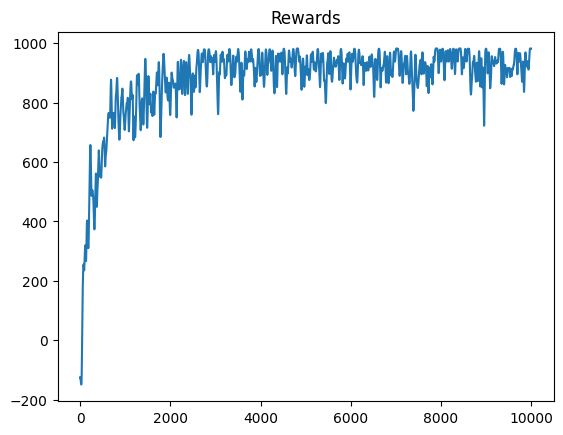

In [169]:
fig, ax = plt.subplots()

# plotting rewards
ax.plot(gaussian_filter1d(train_rewards, sigma=10))
ax.set_title('Rewards')
# show figure
fig.show()

If all went well, your rewards should increase before reaching a treshold.
> This graph depends on the parameters you set at the beginning of the notebook.\
> You can try changing the MAP_SIZE for example for very different results.\
> It is advised to stay below 30 for the MAP_SIZE, otherwise your agent might find that it is a better idea to kill itself rather than reach its goal ! 

Let's check out our Q-table and observe our estimated policy as well as the values for each action-state pair !

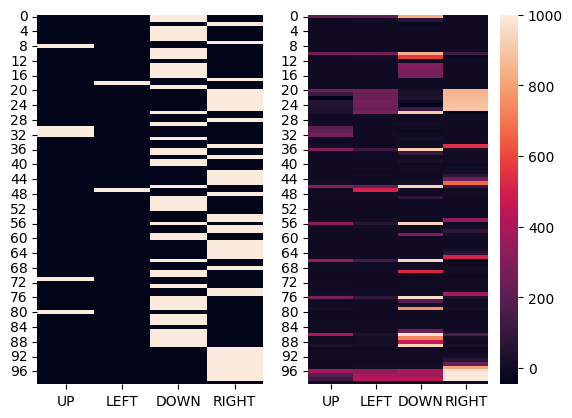

In [170]:
# Extract the optimal actions from the Q-table
best_actions = [np.argmax(x) if np.mean(x) != x[0] else -1 for x in agent.q_table]

# Initialize a matrix for the policy
policy = np.zeros((MAP_SIZE ** 2, len(ACTIONS)))

# Fill in the policy matrix
for y in range(MAP_SIZE ** 2):
    for x in range(MAP_SIZE):
        if x == best_actions[y]:
            policy[y][x] = 1

# Create a figure with two subplots
fig, ax = plt.subplots(1,2)

# Plot the policy matrix as a heatmap
heatmap(policy, ax=ax[0], xticklabels=ACTIONS, cbar=False)

# Plot the Q-table as a heatmap
heatmap(agent.q_table, ax=ax[1], xticklabels=ACTIONS, annot=MAP_SIZE<6)

# Show the figure
fig.show()

This code extracts the optimal actions from the Q-table and uses them to create a matrix representing the policy. It then plots the policy matrix and the Q-table as heatmaps. The policy matrix shows which actions are considered optimal in which states, while the Q-table shows the values of the actions in each state.

Finally, let's record a video of our agent solving the grid world !

MoviePy - Building file output.gif with imageio.


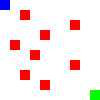

In [171]:
frames = []

# Iterate over the time steps in the episode
for i in range(1000):
    # Add the current state of the environment to the list of frames
    frames.append(np.array(env.graphic()))

    # Choose the greedy action for the current state
    action = agent.epsilon_greedy_policy(state)

    # Interact with the environment to get the new state, reward, and done flag
    new_state, reward, done = env.step(action)

    # Set the new state as the current state
    state = new_state

    # If the episode is done, reset the environment and break out of the loop
    if done is True:
        frames.append(np.array(env.graphic()))
        state = env.reset()
        break

clip = ImageSequenceClip(list(frames), fps=20)
clip.resize(width=300)
clip.write_gif('output.gif', fps=20)
Image('output.gif', width=300)

### Conclusion

Awesome ! You've managed to implement the Q-Learning algorithm in python !

Isn't it cool to see the agent go from not knowing anything to seamlessly running through the maze while avoiding all obstacles ?

What happens if the maze is bigger, though ? Increase the value of the `MAP_SIZE` constant at the top of the notebook to see the changes. Beware though; this environment is not suited for large sizes, so stay below 30 if you want good results. Also, the larger the size, the long it will take your agent to learn. You can also change the episode count and length, if you want !

Hopefully this notebook was fun. We decided to spare you the creation of the environment because that doesn't teach you anything about AI and it would be a little time consuming for what it's worth.

In the next notebook, `REINFORCE.ipynb`, we'll show you a great tool that is used in RL to easily deal with pre-made environments which are tailor-made for RL ! We will also be implementing a policy-based, on-policy, monte carlo algorithm !\
Basically the opposite to Q-Learning !